# Matching Test

In [39]:
import sys
from glob import glob
from os import path as osp
from datetime import datetime
from tqdm import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
# torch imports
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
from os import path as osp
import sys

# get root directory
import re
reg = '^.*/AquaPose'
project_root = re.findall(reg, osp.dirname(osp.abspath(sys.argv[0])))[0]
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset

from lib.models.keypoint_rcnn import get_resnet50_pretrained_model

# utils
from lib.utils.slack_notifications import slack_message
from lib.utils.select_gpu import select_best_gpu

# references import
# source: https://github.com/pytorch/vision/tree/master/references/detection
from references.engine import train_one_epoch, evaluate
from references.utils import collate_fn


In [40]:
# load dataset to get a set of poses to match to
dataset = PoseDataset([osp.join(project_root,'data/vzf/freestyle/freestyle_2'), osp.join(project_root,'data/vzf/freestyle/freestyle_3')], train=False)


In [41]:
weight_dir = osp.join(project_root, 'weights')
weight_files = glob(osp.join(weight_dir,'*'))
model = get_resnet50_pretrained_model()
print(weight_files)
model.load_state_dict(torch.load(weight_files[-1], map_location=torch.device('cpu')))


['/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_box_and_key_predictor.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_epoch.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_finally_fixed.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_finally_fixed_interrupted.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_only_box.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_breaststroke_epoch0', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_breaststroke_epoch0.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_only_box.w

RuntimeError: unexpected EOF, expected 1286332 more bytes. The file might be corrupted.

In [ ]:
# get list of poses from dataset
poses_dataset = [target['keypoints'][0][4:].numpy() for _ , target in dataset]
#print(poses_dataset)

In [ ]:
# get prediction
demo_dir = osp.join(project_root, 'demo_data')
image_files = glob(osp.join(demo_dir, '*'))
image = io.imread(image_files[4])
image_tensor = transforms.ToTensor()(image)
model.eval()
prediction = model([image_tensor])

In [ ]:
keypoints_scores = prediction[0]['keypoints_scores']
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']
keypoints = prediction[0]['keypoints']

fig, ax = plt.subplots()

plt.imshow(image_tensor.permute(1,2,0).detach().numpy())
max_score = 0
max_box = []
for idx, box in enumerate(boxes):
    if scores[idx].item() > max_score:
        print(labels[idx].data.numpy())
        max_score = scores[idx].item()
        max_box = box
        max_keypoints = keypoints[idx] 
        max_keypoints_scores = keypoints_scores[idx]

predicted_pose = max_keypoints[4:].detach().numpy()
prediction_scores = max_keypoints_scores[4:].detach().numpy()

min_keypoint_score = 0
keypoints_min_score = predicted_pose[[np.argwhere(prediction_scores > min_keypoint_score)]]
#annotations_min_score = np.array(list(annotation_keypoints.values()))[[np.argwhere(max_keypoints_scores.detach().numpy() > min_keypoint_score)]]

ax.scatter(np.array(keypoints_min_score)[:,0,0],np.array(keypoints_min_score)[:,0,1], s=10, marker='.', c='r')

# # annotate points on image
# for i, annotation in enumerate(annotations_min_score):
#     print(annotation)
#     if "fdafda" in annotation[0]:
#         ax.annotate(annotation, (np.array(keypoints_min_score)[i,0,0], np.array(keypoints_min_score)[i,0,1]))
print(prediction_scores)

In [ ]:
print(predicted_pose)
print(prediction_scores)

In [ ]:
id = 23
vis_ind = [np.argwhere(poses_dataset[id][:,2] > 0)]
pos_score_ind = [np.argwhere(prediction_scores > 0)]
filter_ind = np.intersect1d(vis_ind, pos_score_ind)

ref_pose = poses_dataset[id][filter_ind]
pred_pose = predicted_pose[filter_ind]

A, res, rank, s = np.linalg.lstsq(pred_pose, ref_pose)
A[np.abs(A) < 1e-10] = 0  # set really small values to zero

pose_warped = np.dot(pred_pose, A)
print(pose_warped)

In [ ]:
start = 10
stop = 25
images = [dataset[i][0] for i in range(start,stop)]

def tensor_to_numpy_image(t):
    return t.permute(1, 2, 0).numpy()

def images_grid(images, rows, columns):
    fig=plt.figure(figsize=(10, 10))

    if len(images) > rows*columns:
        print('too much images for given rows and columns')

    for i, img in enumerate(images):
        id = range(start,stop)[i]

        fig.add_subplot(rows, columns, i + 1)
        subfig = plt.figure(figsize=(10,10))
        ax = subfig.gca()
        plt.imshow(tensor_to_numpy_image(images[i]))

        poses_dataset[range(start,stop)[i]]

        vis_ind = [np.argwhere(poses_dataset[id][:,2] > 0)]
        pos_score_ind = [np.argwhere(prediction_scores > 0)]
        filter_ind = np.intersect1d(vis_ind, pos_score_ind)
        print(filter_ind)

        ref_pose = poses_dataset[id][filter_ind]
        pred_pose = predicted_pose[filter_ind]

        A, res, rank, s = np.linalg.lstsq(pred_pose, ref_pose)
        A[np.abs(A) < 1e-10] = 0  # set really small values to zero

        pose_warped = np.dot(pred_pose, A)

        ax.scatter(ref_pose[:,0], ref_pose[:,1], s=10, marker='.', c='b')
        ax.scatter(pose_warped[:,0], pose_warped[:,1], s=10, marker='.', c='r')
        ax.scatter(pred_pose[:,0], pred_pose[:,1], s=10, marker='.', c='g')   
        plt.show()

images_grid(images, 3,5)

# draw original annotations
#ax.scatter(np.array(keypoints_min_score)[:,0,0],np.array(keypoints_min_score)[:,0,1], s=10, marker='.', c='r')
# ax.scatter(ref_pose[:,0], ref_pose[:,1], s=10, marker='.', c='b')
# ax.scatter(pose_warped[:,0], pose_warped[:,1], s=10, marker='.', c='r')
# ax.scatter(pred_pose[:,0], pred_pose[:,1], s=10, marker='.', c='g')

In [ ]:
def calc_distance(pred_pose, pred_pose_scores, ref_pose, ref_box):
    # use box diagonal to make distance scale_invariant
    box_diag = 0.001 * sqrt((ref_box[2]-ref_box[0])**2 + (ref_box[3] - ref_box[1])**2)

    vis_ind = [np.argwhere(ref_pose[:10,2] > 0)]
    pos_score_ind = [np.argwhere(prediction_scores > 0)]
    filter_ind = np.intersect1d(vis_ind, pos_score_ind)
    pred_pose_scores_filtered = pred_pose_scores[filter_ind]

    ref_pose_filtered = ref_pose[filter_ind]
    pred_pose_filtered = pred_pose[filter_ind]

    A, res, rank, s = np.linalg.lstsq(pred_pose_filtered, ref_pose_filtered)
    A[np.abs(A) < 1e-10] = 0  # set really small values to zero

    pose_warped = np.dot(pred_pose, A)

    dist = 0
    for pred_kp, ref_kp, score_kp in zip(pose_warped, ref_pose_filtered, pred_pose_scores_filtered):
        # keypoints with high scores have higher weight
        dist += score_kp * np.linalg.norm(pred_kp - score_kp)**2
    
    # normalize with sum of all scores
    dist /= np.sum(pred_pose_scores_filtered)
    # normalize by number of keypoints
    dist /= len(pred_pose_filtered)
    # normalize by diagonal of reference box
    dist /= box_diag**len(pred_pose_filtered)

    return dist

In [ ]:


dists = []
for _, target in [dataset[i] for i in range(0,len(dataset))]:
    dists += [calc_distance(predicted_pose, prediction_scores, target['keypoints'][0].detach().numpy(), target['boxes'][0].detach().numpy())]

#dists = np.array(dists)
n = 10
least_ind = np.argsort(dists)[:n]

print(len(dists))
print(len(dataset))



In [ ]:
for i, idx in enumerate(least_ind):
        sample = dataset[idx]
        img = sample[0]

        fig.add_subplot(3, 5, i + 1)

        subfig = plt.figure(figsize=(10,10))
        ax = subfig.gca()
        plt.imshow(tensor_to_numpy_image(sample[0]))

        vis_ind = [np.argwhere(poses_dataset[idx][:,2] > 0)]
        pos_score_ind = [np.argwhere(prediction_scores > 0)]
        filter_ind = np.intersect1d(vis_ind, pos_score_ind)
        left_ind = [0, 1, 3, 5, 7, 9, 11, 13, 15]
        filter_ind = np.intersect1d(filter_ind, left_ind)
        print(filter_ind)

        ref_pose = poses_dataset[idx][filter_ind]
        pred_pose = predicted_pose[filter_ind]

        A, res, rank, s = np.linalg.lstsq(pred_pose, ref_pose)
        A[np.abs(A) < 1e-10] = 0  # set really small values to zero

        pose_warped = np.dot(pred_pose, A)

        ax.scatter(ref_pose[:,0], ref_pose[:,1], s=10, marker='.', c='b')
        ax.scatter(pose_warped[:,0], pose_warped[:,1], s=10, marker='.', c='r')
        ax.scatter(pred_pose[:,0], pred_pose[:,1], s=10, marker='.', c='g')   
        plt.show()

In [51]:
def resize_bbox_keypoints(bbox, keypoints):
    target_width = 300
    target_height = 100

    bbox_width = abs(bbox[2] - bbox[0])
    bbox_height = abs(bbox[3] - bbox[1])

    x_factor = target_width / bbox_width
    y_factor = target_height / bbox_height

    bbox_resized = [bbox[0]*x_factor - bbox[0], bbox[1]*y_factor - bbox[1], bbox[2]*x_factor - bbox[0], bbox[3]*y_factor - bbox[1]] 

    keypoints_resized = [[keypoint[0]*x_factor - bbox[0], keypoint[1]*y_factor - bbox[1], keypoint[2]] for keypoint in keypoints]

    pos_score_ind = [np.argwhere(prediction_scores > 0)]
    filter_ind = []
    for idx, keypoint in enumerate(keypoints_resized):
        if keypoint[0] > bbox_resized[0] or keypoint[0] < bbox_resized[2] or keypoint[1] > bbox_resized[1] or keypoint[1] < bbox_resized[3]:
            filter_ind += [idx]

    return bbox_resized, keypoints_resized, filter_ind

In [52]:
def calc_dist_resized(keypoints1, scores, keypoints2):
    dist = 0
    for keypoint1, score, keypoint2 in zip(keypoints1, scores, keypoints2):
        dist += score * np.linalg.norm(keypoint1 - keypoint2)**2

    dist /= np.sum(scores)
    return dist

In [53]:
dists = []

pred_bbox = max_box.detach().numpy()
pred_kp = max_keypoints[4:].detach().numpy()
pred_scores = max_keypoints_scores[4:].detach().numpy()
pred_bbox_resized, pred_kp_resized, filter_ind = resize_bbox_keypoints(pred_bbox, pred_kp)

filter_ind = np.intersect1d(filter_ind, [np.argwhere(pred_scores > 0)])

for _, target in [dataset[i] for i in range(0,len(dataset))]:
    ref_bbox = target['boxes'][0].detach().numpy()
    ref_kp = target['keypoints'][0][4:].detach().numpy()

    ref_bbox_resized, ref_kp_resized, ref_filter_ind = resize_bbox_keypoints(ref_bbox, ref_kp)
    filter_ind = np.intersect1d(filter_ind, ref_filter_ind)

    pred_kp_resized_filtered = np.array(pred_kp_resized)[filter_ind]
    ref_kp_resized_filtered = np.array(ref_kp_resized)[filter_ind]
    scores_filtered = pred_scores[filter_ind]


    dists += [calc_dist_resized(pred_kp_resized_filtered, scores_filtered, ref_kp_resized_filtered)]

#dists = np.array(dists)
n = 10
least_ind = np.argsort(dists)[:n]
print(least_ind)
print(len(dists))
print(len(dataset))



[16 15 17 11 14 13  2  3 53 54]
79
79


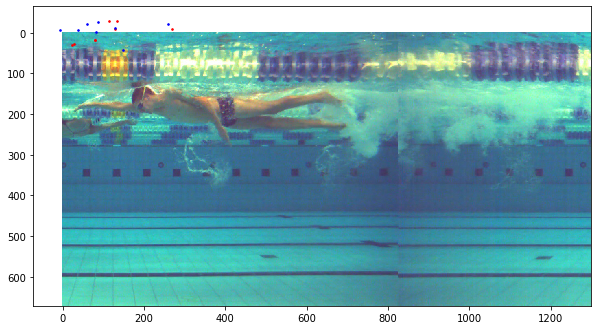

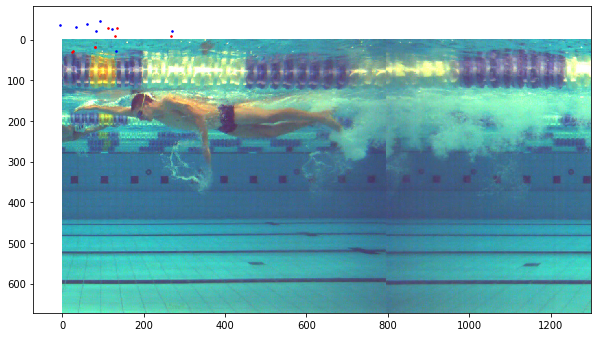

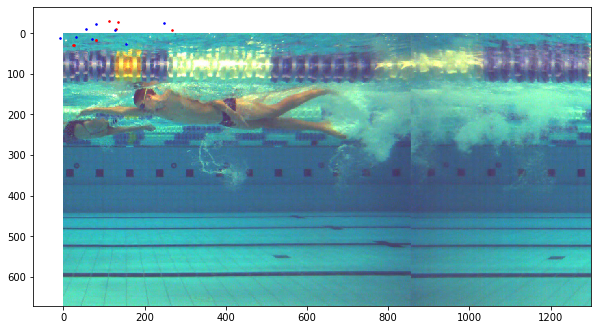

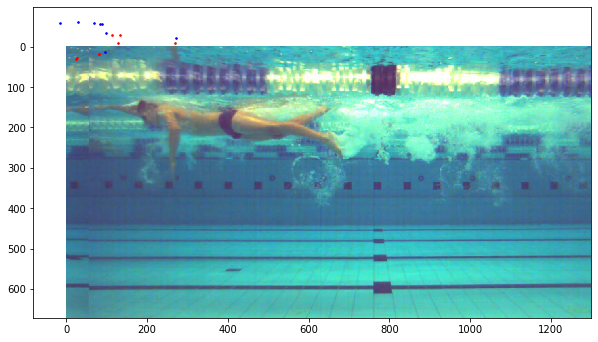

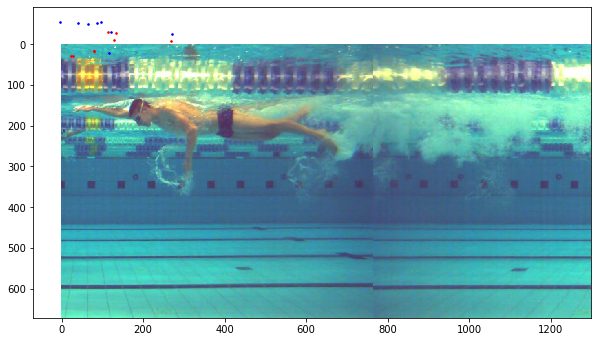

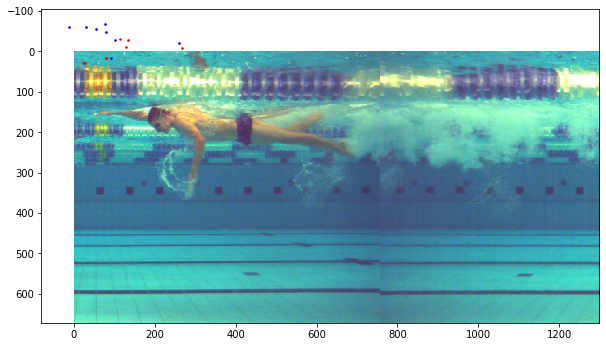

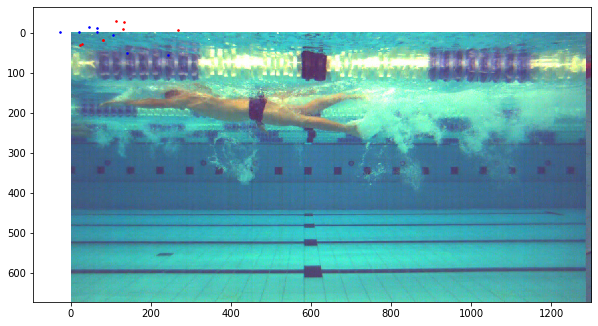

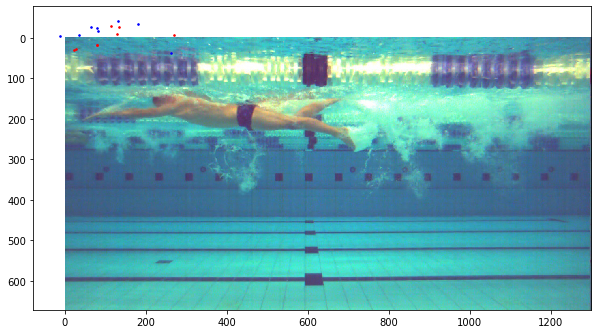

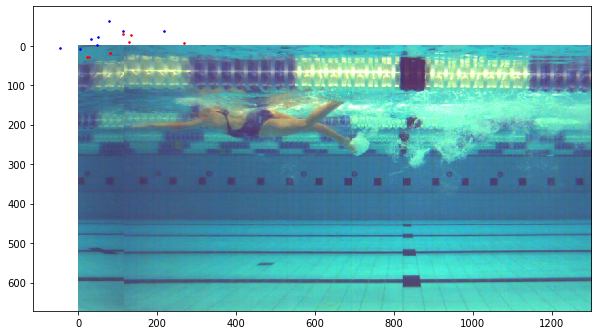

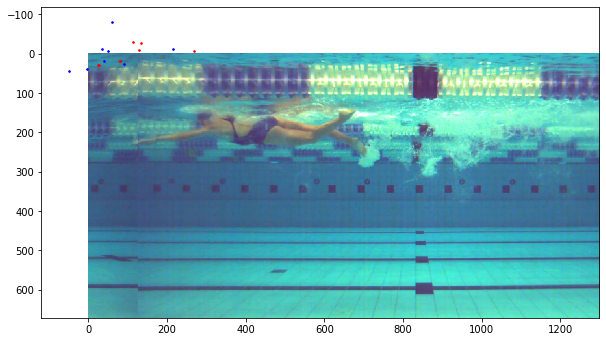

In [54]:
for (img, target) in [dataset[i] for i in least_ind]:
    ref_bbox = target['boxes'][0].detach().numpy()
    ref_kp = target['keypoints'][0][4:].detach().numpy()

    ref_bbox_resized, ref_kp_resized, ref_filter_ind = resize_bbox_keypoints(ref_bbox, ref_kp)
    filter_ind = np.intersect1d(filter_ind, ref_filter_ind)

    pred_kp_resized_filtered = np.array(pred_kp_resized)[filter_ind]
    ref_kp_resized_filtered = np.array(ref_kp_resized)[filter_ind]
    scores_filtered = pred_scores[filter_ind]

    plot_subfig(img, pred_kp_resized_filtered, ref_kp_resized_filtered)


def plot_subfig(image_tensor, kp1, kp2):
    subfig = plt.figure(figsize=(10,10))
    ax = subfig.gca()
    plt.imshow(tensor_to_numpy_image(image_tensor))

    ax.scatter(kp1[:,0], kp1[:,1], s=10, marker='.', c='r')
    ax.scatter(kp2[:,0], kp2[:,1], s=10, marker='.', c='b')
     
    plt.show()